In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [3]:
from fx_analysis import reer_vol, imf_import, import_imf_dic

### Importing the data

In [4]:
os.chdir('/Users/talespadilha/Dropbox/Soft Power and FX Prediction/Data')
df0 = pd.read_csv('sub_indices.csv', header = [0,1], index_col = [0], parse_dates=True)
sub_indices = df0.loc[:'2019-01-01']
latest = sub_indices.iloc[-1]
sub_latest = latest.unstack('subindex').dropna(how='any')

In [5]:
index = pd.read_csv('index.csv', header = [0], index_col = [0], parse_dates=True)
idx_latest = index.iloc[-1]

### Clustering Subindices

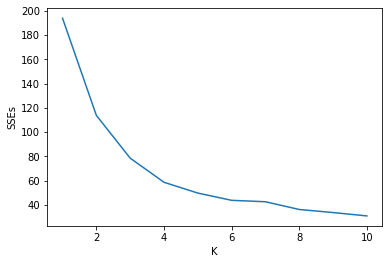

In [6]:
k_range = range(1,11)
sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(sub_latest)
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('SSEs')
plt.plot(k_range, sse)

Estimating the model with optimal K:

In [7]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict(sub_latest)
sub_latest['cluster'] = clusters
sub_latest.head()

subindex,comercial,culture,digital,education,global_reach,institutions,cluster
country,,,,,,,
ALB,-0.022275,-0.001080,-0.107797,-0.532450,0.007836,-0.170469,0
ARG,-0.032280,0.361190,0.418772,-0.672538,0.135909,-0.210682,0
AUS,0.520881,0.874991,0.386663,1.651744,0.317083,1.327427,2
AUT,0.685246,0.493211,0.534771,1.113295,0.171318,1.301079,2
AZE,0.164170,-0.045553,0.241126,-0.874079,0.046039,-0.537509,0


In [8]:
for i in range(0,4):
    ccs = sub_latest[sub_latest['cluster']==i].index
    print(f"Countries in {i}")
    print(ccs)

Countries in 0
Index(['ALB', 'ARG', 'AZE', 'BGR', 'BLR', 'BRA', 'CHL', 'COL', 'CRI', 'DOM',
       'DZA', 'IDN', 'JOR', 'KAZ', 'LBN', 'MAR', 'MDA', 'MEX', 'MLT', 'MYS',
       'PAN', 'PER', 'PHL', 'QAT', 'ROU', 'RUS', 'SAU', 'SRB', 'THA', 'TTO',
       'TUN', 'TUR', 'UKR', 'URY', 'VNM'],
      dtype='object', name='country')
Countries in 1
Index(['CHE', 'CHN', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA', 'USA'], dtype='object', name='country')
Countries in 2
Index(['AUS', 'AUT', 'BEL', 'CAN', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'GRC',
       'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'LTU', 'LUX', 'LVA', 'NLD', 'NOR',
       'NZL', 'POL', 'PRT', 'SGP', 'SVK', 'SVN', 'SWE'],
      dtype='object', name='country')
Countries in 3
Index(['JPN', 'KOR'], dtype='object', name='country')


In [9]:
# Adding index
sub_latest['index'] = idx_latest

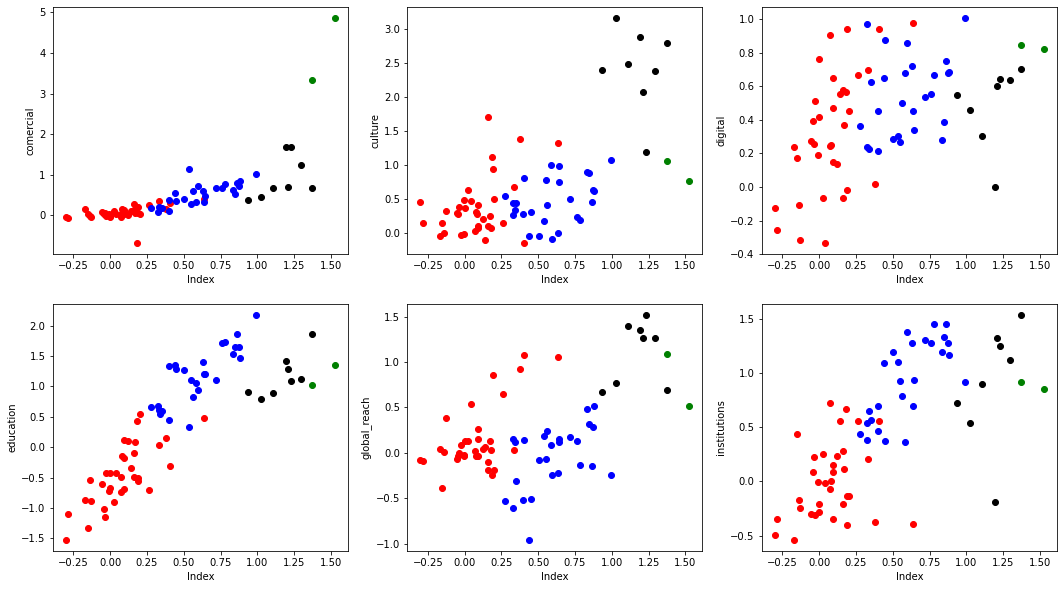

In [10]:
# Prep Plot
df0 = sub_latest[sub_latest['cluster']==0]
df1 = sub_latest[sub_latest['cluster']==1]
df2 = sub_latest[sub_latest['cluster']==2]
df3 = sub_latest[sub_latest['cluster']==3]
columns = ['comercial', 'culture', 'digital', 'education', 'global_reach', 'institutions']
# Plot
fig, ax = plt.subplots(2, 3, figsize = (18, 10))
ids = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
for id_key, col in enumerate(columns, 0):
    idx = ids[id_key]
    ax[idx].plot(df0['index'], df0[col], 'o', color='red')
    ax[idx].plot(df1['index'], df1[col], 'o', color='black')
    ax[idx].plot(df2['index'], df2[col], 'o', color='blue')
    ax[idx].plot(df3['index'], df3[col], 'o', color='green')
    ax[idx].set_xlabel('Index')
    ax[idx].set_ylabel(col)

In [19]:
pd.Series(index.columns.unique()).to_csv('final_list.csv')

### Checking REER

In [10]:
cc_dict = import_imf_dic()
reer0 = imf_import('Raw Data/', 'reer_imf.xlsx')
reer = reer0.rename(columns=cc_dict)
fx_vol = reer_vol(reer)

/Users/talespadilha/Documents/Projects/soft_power/fx_analysis.py:33: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  data0 = pd.read_excel(data_path+file_name, header = [0,1], index_col = [0,1])


In [17]:
regimes = pd.read_csv('fx_regime.csv', index_col = [1])[['Regime']]
ff = list(regimes.loc[regimes.Regime=='ff'].index)
cl = list(regimes.loc[regimes.Regime=='cl'].index)
all_ccs = ff

In [18]:
plt_dict = {}
plt_dict['fx_vol'] = fx_vol.reindex(all_ccs, axis=1)
plt_dict['index'] = index.reindex(all_ccs, axis=1)
plt_data = pd.concat(plt_dict, axis=1).stack(level=1).dropna()

In [19]:
plt_data['cluster'] = np.nan
for i in plt_data.index:
    plt_data.loc[i, 'cluster'] = sub_latest.loc[i[1]]['cluster']

Text(0, 0.5, 'fx_vol')

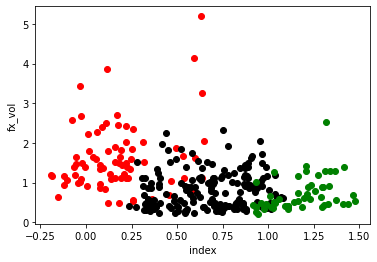

In [26]:
# Prep Plot
df0 = plt_data[plt_data['cluster']==0]
df1 = plt_data[plt_data['cluster']==1]
#df2 = plt_data[plt_data['cluster']==2]
df3 = plt_data[plt_data['cluster']==3]
plt.scatter(df0['index'], df0.fx_vol, color='red')
plt.scatter(df1['index'], df1.fx_vol, color='black')
#plt.scatter(df2['index'], df2.fx_vol, color='blue')
plt.scatter(df3['index'], df3.fx_vol, color='green')
plt.xlabel('index')
plt.ylabel('fx_vol')

In [21]:
plt_data.groupby('cluster').mean().

,fx_vol,index
cluster,,
0.0,1.612662,0.170608
1.0,0.804417,0.666063
2.0,1.625766,1.451431
3.0,0.700656,1.170553


In [16]:
plt_data.loc[plt_data['cluster']==0]

fx_vol     index  cluster
2011-01-01 BRA  1.595552  0.245445      0.0
           CHL  1.486821  0.183419      0.0
           COL  1.394935 -0.064148      0.0
           MLT  0.785717  0.582444      0.0
           MEX  1.649838  0.186644      0.0
...                  ...       ...      ...
2019-01-01 MDA  1.101772 -0.026830      0.0
           PHL  0.639136 -0.151019      0.0
           RUS  1.112506  0.635147      0.0
           UKR  1.808938  0.122373      0.0
           URY  1.087284  0.138650      0.0

[76 rows x 3 columns]